In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, LeakyReLU, \
                                    ReLU, UpSampling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

import warnings
import os
import scipy.misc as misc
import imageio as io
import traceback
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/My\ Drive/imgs.zip .

In [ ]:
!unzip imgs.zip

Archive:  imgs.zip
   creating: imgs/
  inflating: imgs/Content009.png     
  inflating: imgs/Output003.png      
  inflating: imgs/Style007.png       
  inflating: imgs/Style003.png       
  inflating: imgs/Style008.png       
  inflating: imgs/Content007.png     
  inflating: imgs/Output007.png      
  inflating: imgs/Content008.png     
  inflating: imgs/Output008.png      
  inflating: imgs/Style005.png       
  inflating: imgs/Style004.png       
  inflating: imgs/Style001.png       
  inflating: imgs/Output011.png      
  inflating: imgs/Content011.png     
  inflating: imgs/Output004.png      
  inflating: imgs/Content001.png     
  inflating: imgs/Output002.png      
  inflating: imgs/Content003.png     
  inflating: imgs/Output010.png      
  inflating: imgs/Content006.png     
  inflating: imgs/Content002.png     
  inflating: imgs/Output001.png      
  inflating: imgs/Content010.png     
  inflating: imgs/Output006.png      
  inflating: imgs/Style002.png       
  inflating:

In [2]:
CONTENT_PATH = './samples/content/'
STYLE_PATH = './samples/style'

## Donwloading the Dataset

### Downloading Content Images

In [ ]:
def download_dataset_to_path(path, url):
    if path[-1] != '/':
        path = path + '/'

    print("Creating path " + path + ' ...\n')
    !mkdir $path -p

    print('Downloading data ...\n')
    !wget $url -P $path
    files = !ls $path

    file_path = path + files[0]
    print("\nExtracting files from zip ...\n")
    !unzip -q $file_path -d $path

    print("Removing the zip to free disk space ...")
    !rm $file_path

In [ ]:
CONTENT_URL = 'http://images.cocodataset.org/zips/train2014.zip'
CONTENT_PATH = './datasets/content/'

In [ ]:
# download_dataset_to_path(CONTENT_PATH, CONTENT_URL)

In [ ]:
# style_images = tf.keras.utils.get_file('wikiart.zip', 'http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip', extract=True)
# !rm $style_images

In [ ]:
STYLE_URL = 'http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip'
STYLE_PATH = './datasets/style/'

In [ ]:
download_dataset_to_path(STYLE_PATH, STYLE_URL)

Creating path ./datasets/style/ ...


--2020-06-04 02:17:56--  http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip
Resolving web.fsktm.um.edu.my (web.fsktm.um.edu.my)... 103.18.2.145
Connecting to web.fsktm.um.edu.my (web.fsktm.um.edu.my)|103.18.2.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27301958850 (25G) [application/zip]
Saving to: ‘./datasets/style/wikiart.zip’

wikiart.zip         100%[===================>]  25.43G  7.80MB/s    in 66m 57s 

2020-06-04 03:24:55 (6.48 MB/s) - ‘./datasets/style/wikiart.zip’ saved [27301958850/27301958850]


Extracting files from zip ...

./datasets/style/wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg  bad CRC 3d470143  (should be 90cccc50)
  error:  invalid compressed data to inflate ./datasets/style/wikiart/Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
Removing the zip to free disk space ...


## Preparing the Dataset

In [3]:
IMG_DIM = 288
BATCH_SIZE = 16

In [4]:
content_image_generator = ImageDataGenerator(rescale=1./255)


content_data_generator = content_image_generator.\
                flow_from_directory(directory=CONTENT_PATH,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    target_size=(IMG_DIM, IMG_DIM))

Found 200 images belonging to 1 classes.


In [5]:
style_image_generator = ImageDataGenerator(rescale=1./255)


style_data_generator = style_image_generator.\
                flow_from_directory(directory=STYLE_PATH,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    target_size=(IMG_DIM, IMG_DIM))

Found 197 images belonging to 1 classes.


In [6]:
def get_one_mixed_batch():
    contentX, _ = next(content_data_generator)
    try:
        styleX, _ = next(style_data_generator)
    except:
        return get_one_mixed_batch()
    
    if contentX.shape[0] == styleX.shape[0]:
        return contentX, styleX
    
    return get_one_mixed_batch()

In [7]:
a, b = get_one_mixed_batch()
a.shape, b.shape

((16, 288, 288, 3), (16, 288, 288, 3))

In [8]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

## Defining the Model

In [9]:
content_layer = 'block4_conv1'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block3_conv2']

num_style_layers = len(style_layers)

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

### Encoder

In [11]:
def get_vgg_encoder(final_layer):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data

    outputs = vgg.get_layer(final_layer).output
    model = tf.keras.Model([vgg.input], outputs, name = 'VGG_Encoder')
    return model

In [12]:
def get_vgg_style_extractor(style_layers = style_layers):
    outputs = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    return tf.keras.Model([vgg.input], outputs)

In [13]:
vgg_style_model = get_vgg_style_extractor()

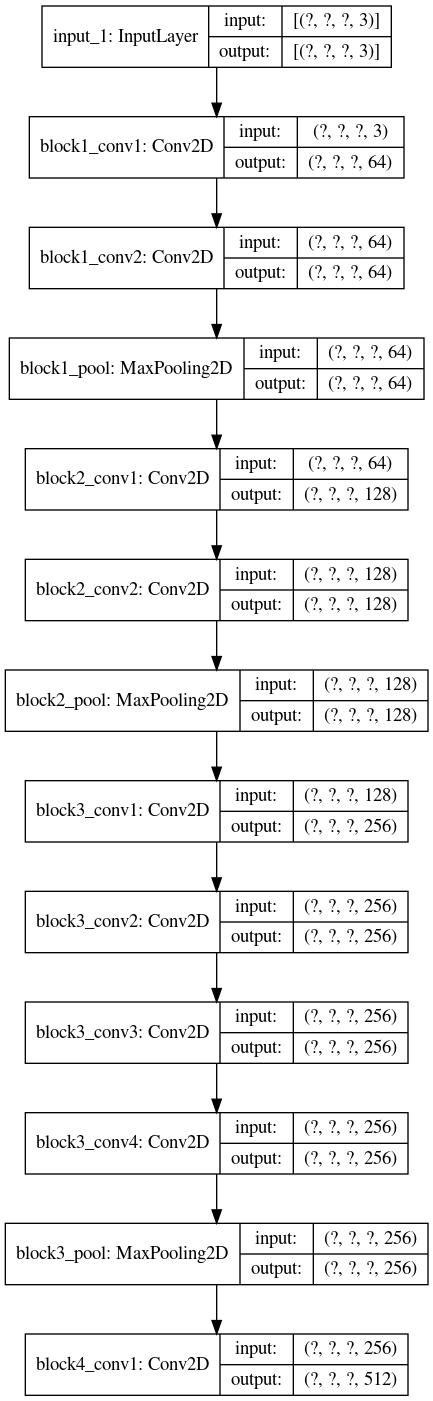

In [14]:
encoder = get_vgg_encoder(content_layer)


tf.keras.utils.plot_model(
    encoder, to_file='VGGEncoder.png', show_shapes=True)

### Decoder

In [15]:
def get_decoder():
    features = tf.keras.Input(shape = (None, None, 512,), name = 'InputFeatures')

    h = Conv2D(256, (3,3), padding='same', name='Block4_Conv1')(features)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_3')(h)

    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv4')(h)
    h = ReLU()(h)
    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv3')(h)
    h = ReLU()(h)
    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv2')(h)
    h = ReLU()(h)
    h = Conv2D(128, (3,3), padding='same', name='Block3_Conv1')(h)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_2')(h)

    h = Conv2D(128, (3,3), padding='same', name='Block2_Conv2')(h)
    h = ReLU()(h)
    h = Conv2D(64, (3,3), padding='same', name='Block2_Conv1')(h)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_1')(h)

    h = Conv2D(32, (3,3), padding='same', name='Block1_Conv2')(h)
    h = LeakyReLU()(h)
    h = Conv2D(3, (3,3), padding='same', name='Block1_Conv1')(h)

    return tf.keras.Model(features, h, name = 'Decoder')  

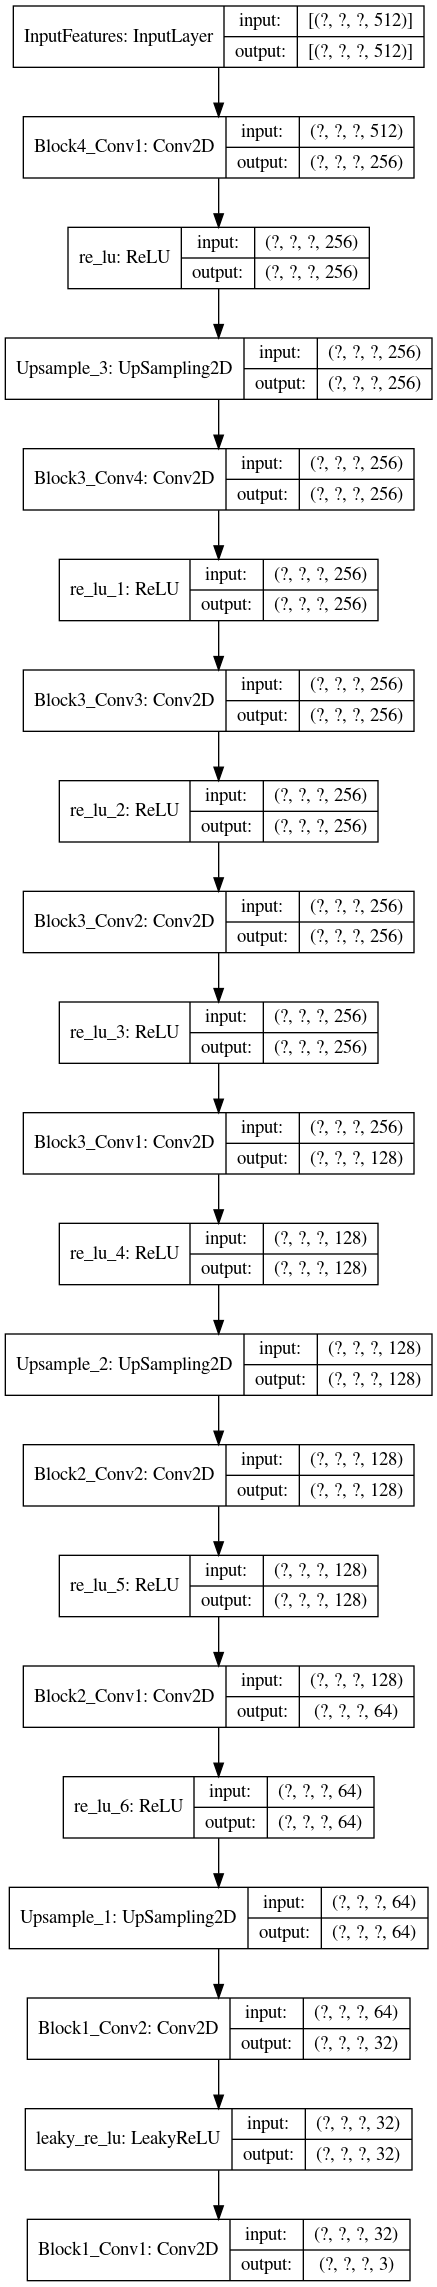

In [16]:
decoder = get_decoder()

tf.keras.utils.plot_model(
    decoder, to_file='adaptive.png', show_shapes=True)

## Models for Style Transfer

### Instance Normalization

In [95]:
def get_adaptive_instance_norm(alpha=1, epsilon = 1e-5):
    content_features = tf.keras.Input(shape=(None, None, 512), name="content_encoded")
    style_features = tf.keras.Input(shape = (None, None, 512), name = "style_encoded")

    content_mean, content_variance = tf.nn.moments(content_features, [1, 2], keepdims=True)
    style_mean, style_variance = tf.nn.moments(style_features, [1, 2], keepdims=True)

    normalized_content_features = tf.nn.batch_normalization(
        content_features, content_mean, content_variance, style_mean, tf.sqrt(style_variance), epsilon
    )
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features

    return tf.keras.Model(inputs=[content_features, style_features], 
                          outputs=normalized_content_features, 
                          name='AdaptiveInstanceNorm')

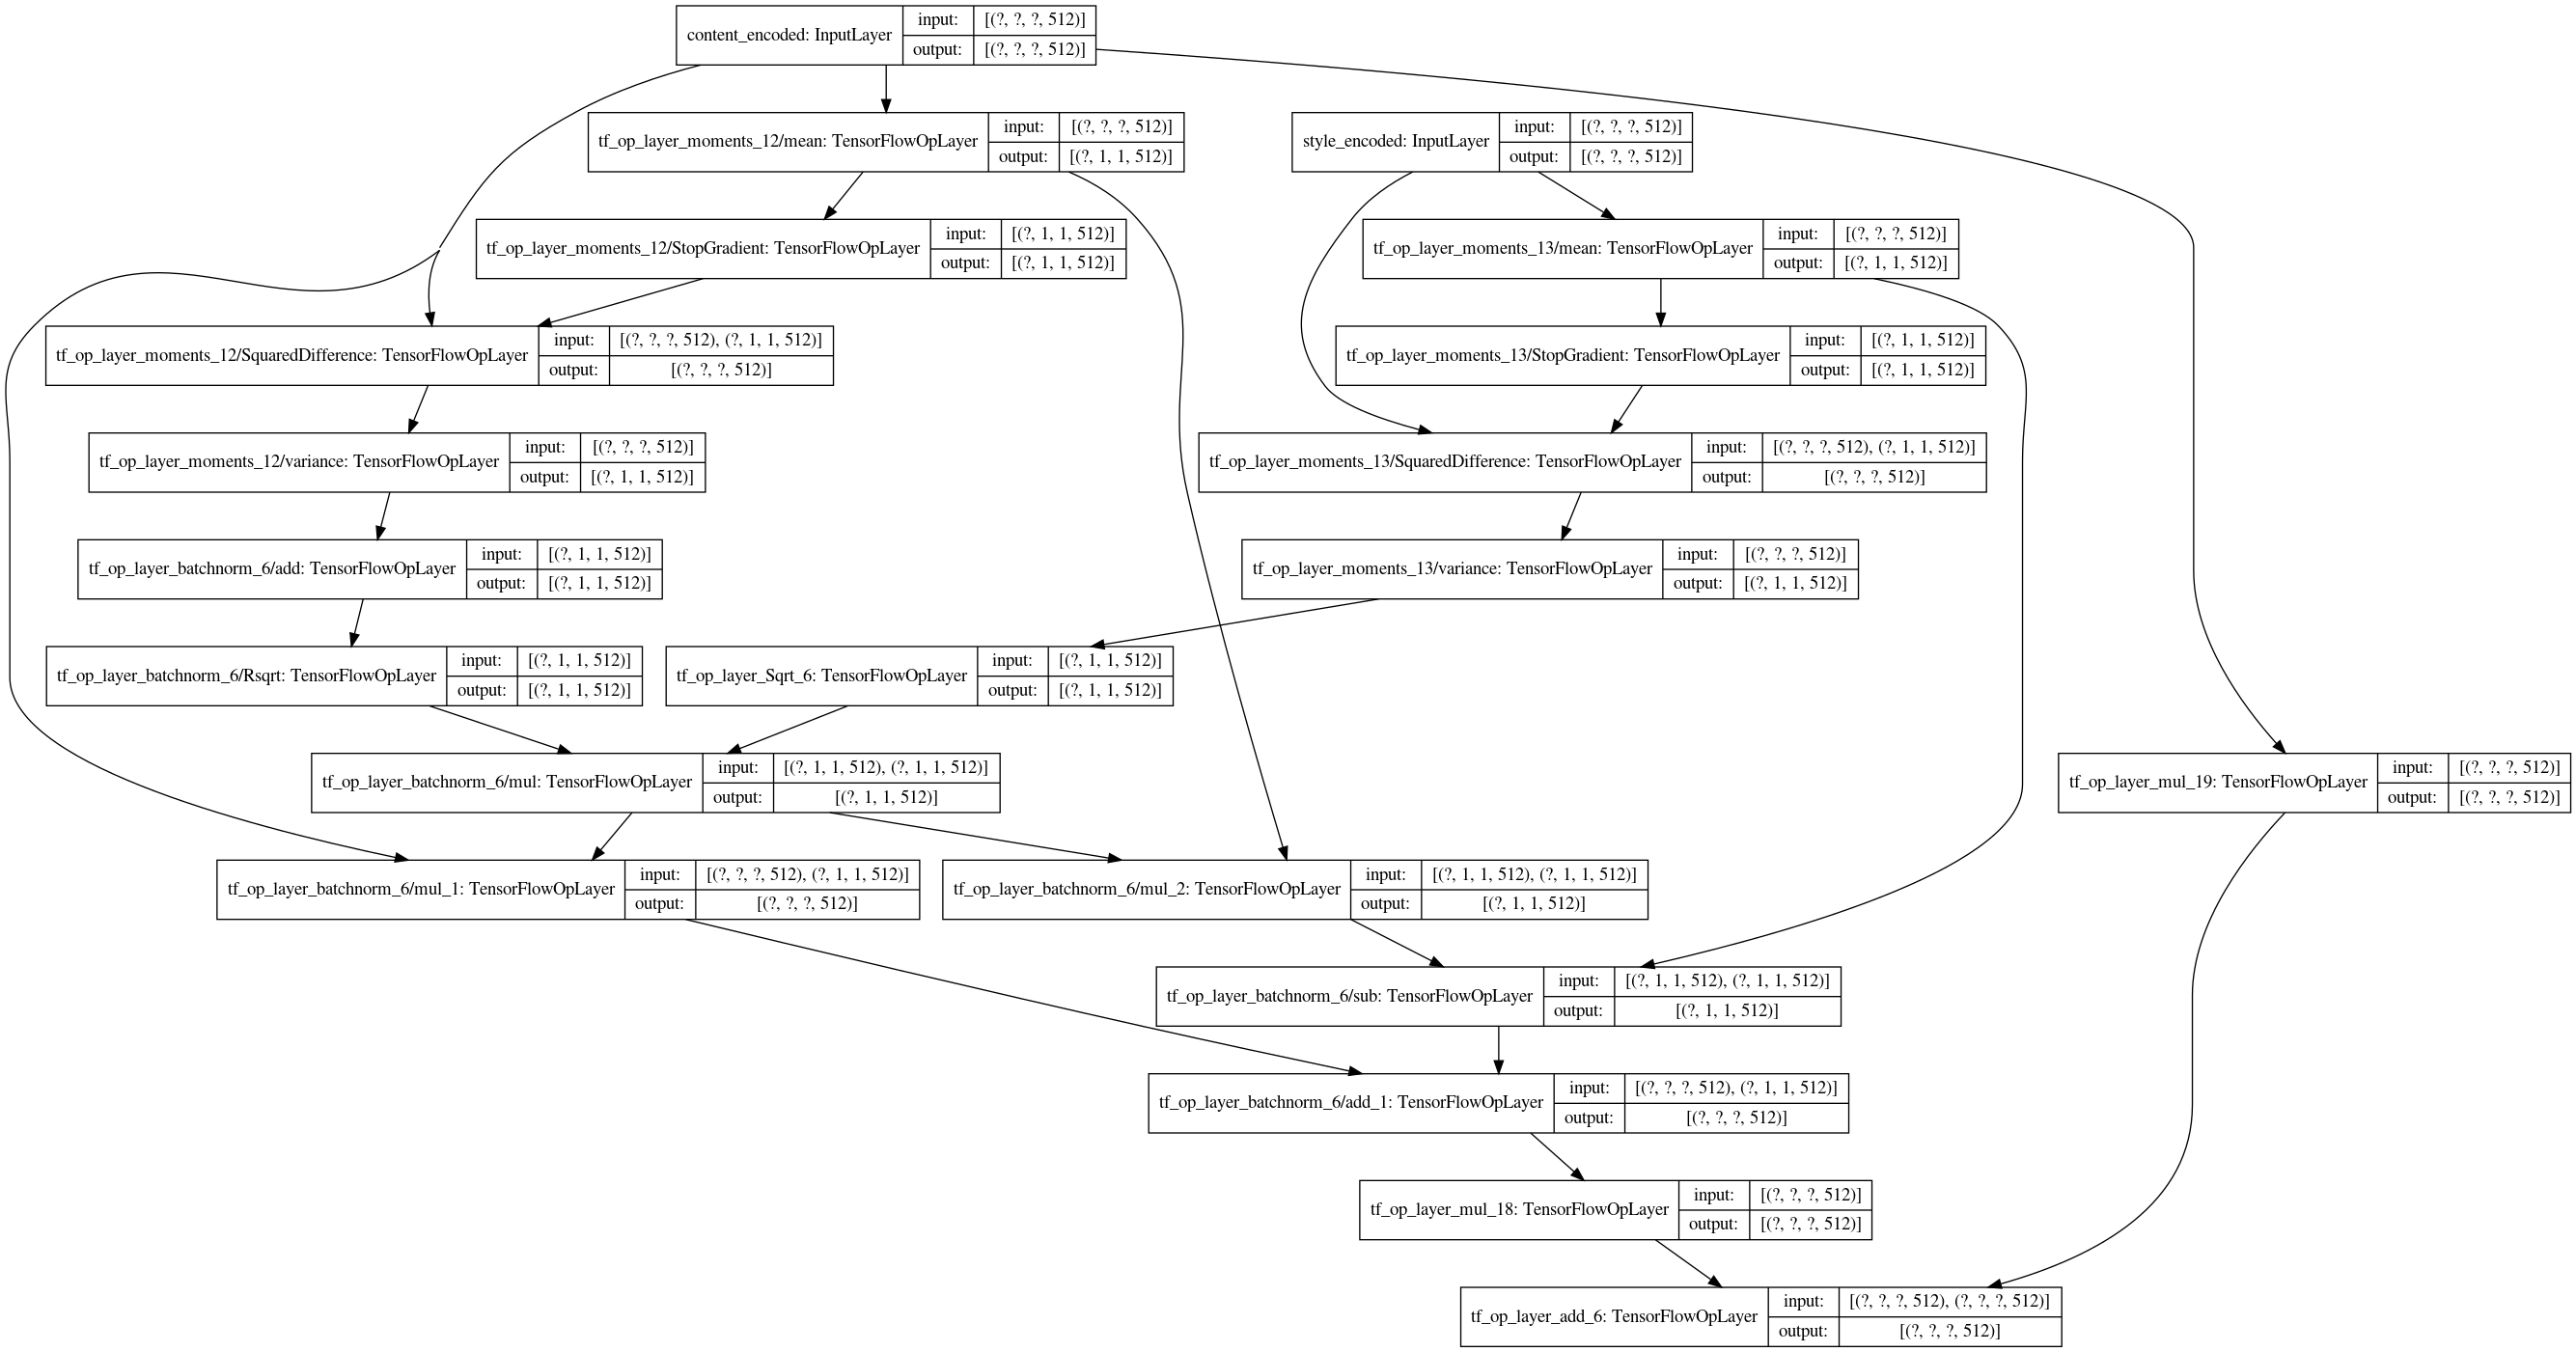

In [96]:
sample_adaptive_instance_norm = get_adaptive_instance_norm()

tf.keras.utils.plot_model(
    sample_adaptive_instance_norm, to_file='AdaptiveInstanceNorm.png', show_shapes=True)

### Style Transfer Model for Training

In [97]:
def get_arbitrary_style_transfer_model(encoder, decoder):
    content_images = tf.keras.Input(shape=(None, None, 3), name="content_images")
    style_images = tf.keras.Input(shape = (None, None, 3), name = "style_images")

    content_images_scaled = content_images * 255.0
    preprocessed_content = tf.keras.applications.vgg19.preprocess_input(content_images_scaled)

    content_encoded = encoder(preprocessed_content)

    style_images_scaled = style_images * 255.0
    preprocessed_styles = tf.keras.applications.vgg19.preprocess_input(style_images_scaled)

    style_encoded = encoder(preprocessed_styles)

    target_features = get_adaptive_instance_norm()([content_encoded, style_encoded])

    generated_image = decoder(target_features)

    return  tf.keras.Model(inputs=[content_images, style_images], outputs=[generated_image, target_features], name='ArbitrayStyleTransfer')

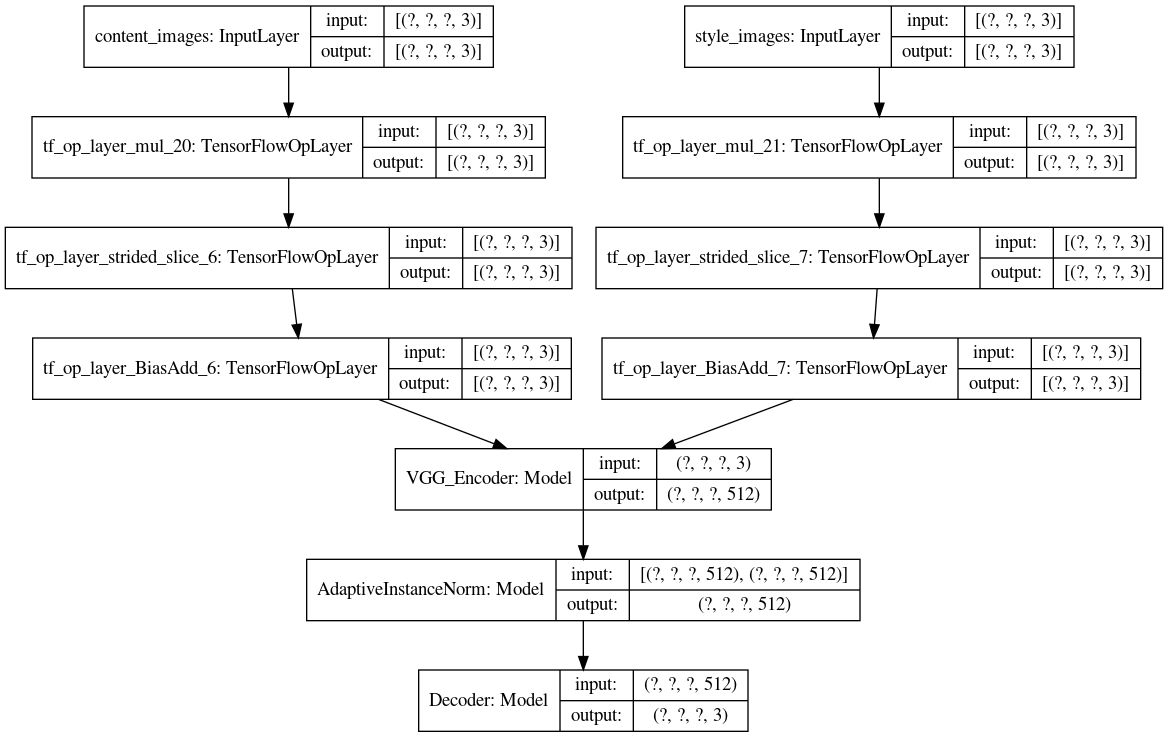

In [98]:
model = get_arbitrary_style_transfer_model(encoder, decoder)

tf.keras.utils.plot_model(
    model, to_file='StyleTranfer.png', show_shapes=True)

In [21]:
model.summary()

Model: "ArbitrayStyleTransfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_images (InputLayer)     [(None, None, None,  0                                            
__________________________________________________________________________________________________
style_images (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_mul_2 (TensorFlowOp [(None, None, None,  0           content_images[0][0]             
__________________________________________________________________________________________________
tf_op_layer_mul_3 (TensorFlowOp [(None, None, None,  0           style_images[0][0]               
______________________________________________________________________________

In [22]:
def compute_style_loss(style_image, generated_image):
    style_features_in_style_image = vgg_style_model(style_image)
    style_features_in_gen_image = vgg_style_model(generated_image)

    style_layer_loss = []
    for style_feat, gen_feat in zip(style_features_in_style_image ,style_features_in_gen_image):
        meanS, varS = tf.nn.moments(style_feat, [1,2])
        meanG, varG = tf.nn.moments(gen_feat, [1,2])

        sigmaS = tf.sqrt(varS + 1e-5)
        sigmaG = tf.sqrt(varG + 1e-5)

        l2_mean = tf.reduce_sum(tf.square(meanG - meanS))
        l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

        style_layer_loss.append(l2_mean + l2_sigma)

    return tf.reduce_sum(style_layer_loss)

In [39]:
def compute_loss(inputs, outputs):
    content_image, style_image = inputs
    generated_image, features = outputs

    ## Finding the content loss
    generated_images_scaled = generated_image * 255.0
    preprocessed_gen = tf.keras.applications.vgg19.preprocess_input(generated_images_scaled)
    gen_encoded = encoder(preprocessed_gen)

    content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(gen_encoded - features), axis = [1,2]))

    ## Finding the style loss
    style_loss = compute_style_loss(style_image, generated_image)
    
    return content_loss + style_loss * 2.0

In [40]:
a, b = get_one_mixed_batch()
inputs = [a, b]
outputs = model(inputs, training = False)
compute_loss(inputs, outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=774536260.0>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


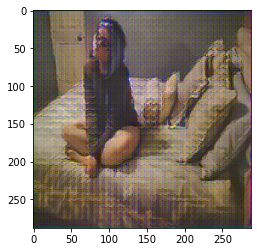

In [41]:
gen_images = outputs[0]
imshow(gen_images[1])

In [42]:
opt = tf.optimizers.Adam(learning_rate=5e-5, beta_1=0.99, epsilon=1e-1)

In [43]:
STYLE_CHECKPOINT_PATH = "./Weights2/Style"

In [44]:
def save_style_weights(model, epoch, path = STYLE_CHECKPOINT_PATH):
    model.save_weights(path + '/weigths{:06d}.h5'.
                     format(epoch))
    print('Saved weights for epoch {}'.format(epoch))

In [45]:
def load_style_weights(epoch, model = decoder, path = STYLE_CHECKPOINT_PATH):
    model.load_weights(path + '/weigths{:06d}.h5'.
                     format(epoch))
    print('Loaded weights for epoch {}'.format(epoch))

In [99]:
load_style_weights(4900)

Loaded weights for epoch 4900


In [49]:
@tf.function()
def train_step(content_images, style_images):
    with tf.GradientTape() as tape:
        outputs = model([content_images, style_images])
        loss = compute_loss([content_images, style_images], outputs)

    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [ ]:
!mkdir -p Weights/Style

In [ ]:
!mv weigths004006.h5 Weights/Style/

In [ ]:
count = len(style_data_generator)
warnings.filterwarnings('ignore')
for epoch in range(4001,5000):
    for i in range(count):
        a, b = get_one_mixed_batch();
        loss = train_step(a, b)

        if i % 50 == 0:
            print('Epoch ', epoch, ' Loss: ', loss)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    if epoch % 100 == 0:
      save_style_weights(decoder, epoch)
      a, b = get_one_mixed_batch()
      inputs = [a, b]
      outputs = model(inputs, training = False)
      imshow(a[0])
      plt.show()
      imshow(b[0])
      plt.show()
      imshow(outputs[0][0])
      plt.show()

In [73]:
a, b = get_one_mixed_batch()
inputs = [a, b]
outputs = model(inputs, training = False)

In [ ]:
for idx in range(16):
    print(idx)
    imshow(a[idx])
    plt.show()
    imshow(b[idx])
    plt.show()
    imshow(outputs[0][idx])
    plt.show()

In [ ]:
!mkdir outputs -p
def save_images(idx, image_id):
    io.imwrite('outputs/Content{:03}.png'.format(image_id), a[idx])
    io.imwrite('outputs/Style{:03}.png'.format(image_id), b[idx])
    io.imwrite('outputs/Output{:03}.png'.format(image_id), outputs[0][idx])

In [ ]:
count = 4

In [ ]:
save_images(12, count)
count = count + 1

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.5473785400390625, 1.6736518144607544]. Convert image to uint8 prior to saving to suppress this warning.


In [100]:
content_files = []
for base_path, _, files in os.walk('./adaptive-style-transfer/images/content'):
    for file in files:
        content_files.append(base_path + '/' + file)
content_files

['./adaptive-style-transfer/images/content/brad_pitt.jpg',
 './adaptive-style-transfer/images/content/lance.jpg',
 './adaptive-style-transfer/images/content/content_3.png',
 './adaptive-style-transfer/images/content/content_2.png',
 './adaptive-style-transfer/images/content/content_4.png',
 './adaptive-style-transfer/images/content/content_5.png',
 './adaptive-style-transfer/images/content/stata.png',
 './adaptive-style-transfer/images/content/content_1.png',
 './adaptive-style-transfer/images/content/chicago.jpg']

In [101]:
style_files = []
for base_path, _, files in os.walk('./adaptive-style-transfer/images/style'):
    for file in files:
        style_files.append(base_path + '/' + file)
style_files

['./adaptive-style-transfer/images/style/style_6.png',
 './adaptive-style-transfer/images/style/style11.png',
 './adaptive-style-transfer/images/style/udnie.jpg',
 './adaptive-style-transfer/images/style/cat.jpg',
 './adaptive-style-transfer/images/style/style_2.png',
 './adaptive-style-transfer/images/style/style_1.png',
 './adaptive-style-transfer/images/style/style_4.png',
 './adaptive-style-transfer/images/style/style_3.png',
 './adaptive-style-transfer/images/style/lion.jpg',
 './adaptive-style-transfer/images/style/style_5.png']

In [102]:
import cv2
import numpy as np
def open_file(file):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    image = image / 255.
    image = cv2.resize(image, (288, 288))
    return image.astype(np.float32)

In [82]:
open_file(content_files[0])

array([[[0.8392157 , 0.8627451 , 0.85490197],
        [0.8392157 , 0.8627451 , 0.85490197],
        [0.83784044, 0.86136985, 0.8535267 ],
        ...,
        [0.8627451 , 0.87058824, 0.85882354],
        [0.8627451 , 0.87058824, 0.85882354],
        [0.8627451 , 0.87058824, 0.85882354]],

       [[0.8392157 , 0.8627451 , 0.85490197],
        [0.8392157 , 0.8627451 , 0.85490197],
        [0.83784044, 0.86136985, 0.8535267 ],
        ...,
        [0.86412036, 0.8719635 , 0.8601988 ],
        [0.8627451 , 0.87058824, 0.85882354],
        [0.8627451 , 0.87058824, 0.85882354]],

       [[0.8392157 , 0.8627451 , 0.85490197],
        [0.8392157 , 0.8627451 , 0.85490197],
        [0.8392157 , 0.8627451 , 0.85490197],
        ...,
        [0.8509804 , 0.85882354, 0.84705883],
        [0.85490197, 0.8627451 , 0.8509804 ],
        [0.85882354, 0.8666667 , 0.85490197]],

       ...,

       [[0.36822048, 0.40743616, 0.44693473],
        [0.41280898, 0.44425884, 0.48735744],
        [0.23314601, 0

In [129]:
def show_images(a,b, c):
    plt.imshow(a)
    plt.show()
    plt.imshow(b)
    plt.show()
    plt.imshow(c)
    plt.show()
    print()

In [130]:
def save_file(output, file_path):
    output = output.numpy()
    output[np.where(output > 1)] = 1
    output[np.where(output < 0)] = 0
    outputasint = (output * 255).astype(np.uint8)
    cv2.imwrite(file_path, cv2.cvtColor(test[0], cv2.COLOR_RGB2BGR))

In [ ]:
cindex = 0
sindex = 0

for content in content_files:
    cimage = open_file(content)
    cimage = cimage.reshape(1, *cimage.shape)
    for style in style_files:
        simage = open_file(style)
        simage = simage.reshape(1, *simage.shape)
        output, _ = model([cimage, simage])
        
        path = 'outputs/' + cindex + '_'+sindex+'/'
        !mkdir -p $path
        
        save_file(path + 'content.png')

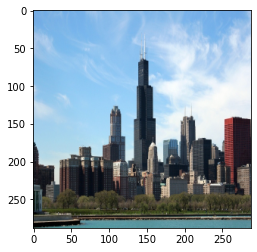

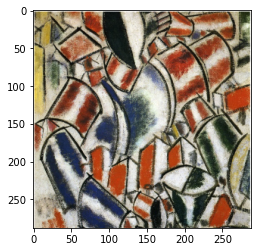

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


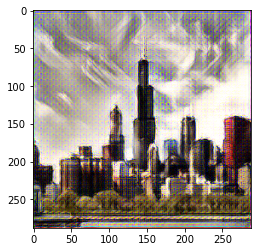

In [105]:
output, _ = model([cimage, simage])
show_images(cimage[0], simage[0], output[0])